In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import load_model, Model
from keras.layers import Input, Dense, LSTM, Activation, Masking, Dropout, Conv1D, GlobalAveragePooling1D, MaxPooling1D, Add
from keras.callbacks import History
from keras import callbacks

# define path to save model
model_path = './cl-fd4-copy/binary_model.h5'
path = './cl-fd4-copy/'

# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv('CMAPSSData/train_FD004.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[4,5,9, 10,14,18,20,22, 23, 26, 27]], axis=1, inplace=True)

train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 's2', 's3','s4', 's7', 's8', 's9', 's11', 's12', 's13',
                     's15', 's17', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv('CMAPSSData/test_FD004.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[4, 5, 9, 10, 14, 18, 20, 22, 23, 26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 's2', 's3','s4', 's7', 's8', 's9', 's11', 's12', 's13',
                     's15', 's17', 's20', 's21']

truth_df = pd.read_csv('CMAPSSData/RUL_FD004.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)


# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
# generate label columns for training data
# we will only make use of "label1" for binary classification, 
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 50
w0 = 25
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

# pick a large window size of 50 cycles
sequence_length = 50

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# pick the feature columns 
sensor_cols = ['s2', 's3','s4', 's7', 's8', 's9', 's11', 's12', 's13','s15', 's17', 's20', 's21']
sequence_cols = ['setting1', 'setting2', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

history = History()

input_layer = Input(shape=(sequence_length, nb_features))
x = Conv1D(50, 6, activation = 'relu')(input_layer)
a = Conv1D(50, 6, activation = 'relu')(x)
x = Conv1D(50, 6, activation = 'relu')(x)
b = Add()([a,x]) #SKIP CONNECTION ADDED
x = MaxPooling1D(3)(b)
x = Conv1D(100, 6, activation = 'relu')(x)
x = Conv1D(100, 6, activation = 'relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = LSTM( units=50, input_shape=(1,100), return_sequences=True)(x)
x = LSTM( units=100, return_sequences=True)(x)
c = LSTM( units=100, return_sequences=True)(x)
x = LSTM( units=100, return_sequences=True)(x)
d = Add()([c,x]) #skip connection
x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
output_layer = Dense(units=nb_out, activation ='sigmoid')(x)
model = Model(input_layer, output_layer)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

model.summary()

2022-02-10 00:03:05.218055: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 16)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 45, 50)       4850        ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 40, 50)       15050       ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 40, 50)       15050       ['conv1d[0][0]']                 
                                                                                              

In [2]:
seq_array.shape

(48799, 50, 16)

In [3]:
test_df['label1'].describe()

count    41214.000000
mean         0.054593
std          0.227187
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: label1, dtype: float64

In [4]:
seq_array[1]

array([[4.76147413e-01, 8.31591427e-01, 1.84501847e-03, 6.47971332e-01,
        6.34407163e-01, 5.11780977e-01, 4.50786859e-01, 8.62888277e-01,
        6.01410568e-01, 6.41233742e-01, 4.50364143e-01, 9.92395043e-01,
        3.51345748e-01, 6.08247399e-01, 4.77968395e-01, 4.81486887e-01],
       [9.99900043e-01, 9.98693585e-01, 3.69003695e-03, 1.23646043e-01,
        2.71244556e-01, 2.22481087e-01, 4.62451670e-03, 6.27110064e-01,
        2.65759289e-01, 4.56168830e-01, 3.20152496e-03, 9.93056297e-01,
        4.23787445e-01, 2.78350502e-01, 1.07635381e-02, 1.89316273e-02],
       [9.99809563e-01, 9.97624695e-01, 5.53505542e-03, 1.21351205e-01,
        2.66167998e-01, 2.24834874e-01, 4.16436605e-03, 6.27025664e-01,
        2.70428121e-01, 4.57792222e-01, 3.64142912e-03, 9.93194103e-01,
        4.01715904e-01, 2.68041223e-01, 1.27817020e-02, 1.87237728e-02],
       [5.95274687e-01, 7.37173378e-01, 7.38007389e-03, 5.69120608e-03,
        3.39156985e-02, 2.20247395e-02, 8.89241695e-02, 1.055

In [5]:
# fit the network
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Epoch 1/100
232/232 [==============================] - 13s 38ms/step - loss: 0.5784 - accuracy: 0.7399 - precision: 0.2381 - recall: 0.0012 - val_loss: 0.5945 - val_accuracy: 0.7230 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
  3/232 [..............................] - ETA: 7s - loss: 0.5573 - accuracy: 0.7533 - precision: 0.0000e+00 - recall: 0.0000e+00

/Users/shrutirajvanshsingh/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


232/232 [==============================] - 8s 33ms/step - loss: 0.5609 - accuracy: 0.7409 - precision: 0.5123 - recall: 0.0225 - val_loss: 0.5040 - val_accuracy: 0.7230 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
232/232 [==============================] - 8s 33ms/step - loss: 0.4487 - accuracy: 0.7561 - precision: 0.5610 - recall: 0.2736 - val_loss: 0.4348 - val_accuracy: 0.7770 - val_precision: 0.8367 - val_recall: 0.2426
Epoch 4/100
232/232 [==============================] - 8s 33ms/step - loss: 0.4158 - accuracy: 0.7844 - precision: 0.6100 - recall: 0.4683 - val_loss: 0.3790 - val_accuracy: 0.8303 - val_precision: 0.7331 - val_recall: 0.6095
Epoch 5/100
232/232 [==============================] - 8s 33ms/step - loss: 0.3332 - accuracy: 0.8450 - precision: 0.7221 - recall: 0.6538 - val_loss: 0.3607 - val_accuracy: 0.8266 - val_precision: 0.6641 - val_recall: 0.7574
Epoch 6/100
232/232 [==============================] - 8s 33ms/step - loss: 0.3073 - accuracy: 0.858

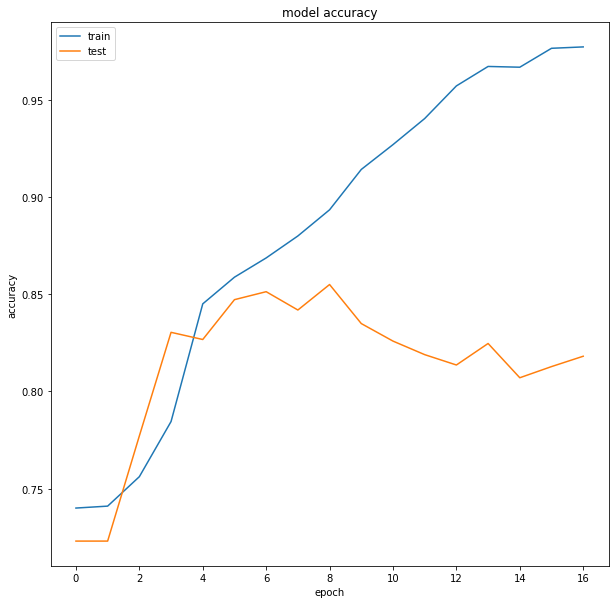

In [6]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(path+"/model_accuracy.png")

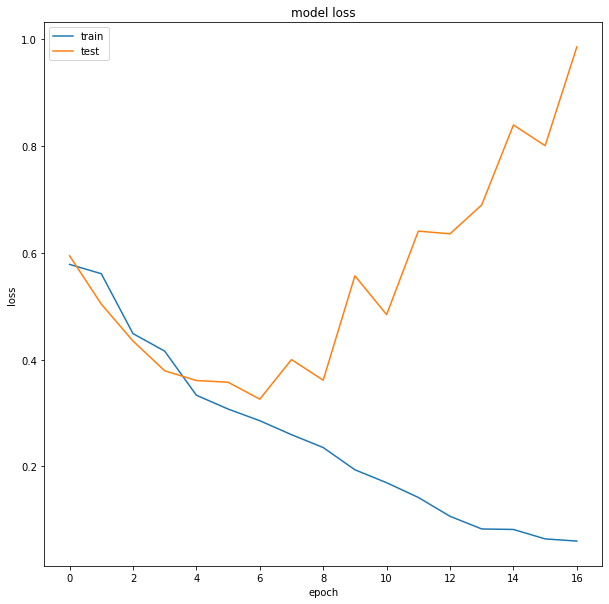

In [7]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(path+"/model_loss.png")

In [8]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))
print('Precision: {}'.format(scores[2]))
print('Recall: {}'.format(scores[3]))

244/244 [==============================] - 2s 8ms/step - loss: 0.0828 - accuracy: 0.9783 - precision: 0.9727 - recall: 0.9429
Accurracy: 0.9782577753067017
Precision: 0.9727051258087158
Recall: 0.9429088830947876


In [9]:
# make predictions and compute confusion matrix
predict_y = model.predict(seq_array,verbose=1) 
y_pred=np.argmax(predict_y, axis=1)
y_true = label_array
test_set = pd.DataFrame(y_pred)
test_set.to_csv(path+'/binary_submit_train.csv', index = None)

1525/1525 [==============================] - 4s 2ms/step


In [10]:
# We pick the last sequence for each id in the test data
from sklearn.metrics import f1_score
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print("seq_array_test_last")
#print(seq_array_test_last)
print(seq_array_test_last.shape)

# Similarly, we pick the labels

#print("y_mask")
# serve per prendere solo le label delle sequenze che sono almeno lunghe 50
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
print("y_mask")
print(y_mask)
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)
print("label_array_test_last")
#print(label_array_test_last)

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path)

# test metrics
scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

# make predictions and compute confusion matrix
predict_y_test = estimator.predict(seq_array_test_last)
y_pred_test = np.argmax(predict_y_test,axis=1)
y_true_test = label_array_test_last

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv(path+'binary_submit_test.csv', index = None)

seq_array_test_last
(228, 50, 16)
y_mask
[True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, 